In [21]:
import six.moves.cPickle as pickle
import gzip
import numpy as np
import matplotlib.pyplot as plt
import random

%matplotlib inline

In [23]:
# transforms an image's numerical label to a vector of length 10 comprised of 0s,
# except for the label's numerical index is represented as a 1
# example: label "5" is represented as a one-hot encoded vector of [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
def one_hot_encode_label(label):
    encoded_label = np.zeros((10, 1), dtype=int)
    encoded_label[label] = 1
    return encoded_label


# create pairs of features and labels.


def shape_data(data):

    # flatten 28×28 pixel input image into a 784 length vector
    # vector values represents a grayscale value between 0 and 1
    # 0 indicating white and 1 indicating black
    features = [np.reshape(x, (784, 1)) for x in data[0]]
    labels = [one_hot_encode_label(y) for y in data[1]]

    return list(zip(features, labels))


# unzip and unpickle the image data set, yielding the training and test data


def load_data():
    with gzip.open("./data/mnist.pkl.gz", "rb") as f:
        train_data, validation_data, test_data = pickle.load(f, encoding="latin1")
        f.close()

    return shape_data(train_data), shape_data(test_data)

In [24]:
# classifies numbers based on label and by averaging their 784 length vector
# allows for comparing images based on an image's numerical average
def average_digit(data, digit):
    # filter values when the digit argument matches the index of the maximum value (the hot-encoded label) within the vector
    filtered_data = [x[0] for x in data if np.argmax(x[1]) == digit]
    filtered_array = np.asarray(filtered_data)
    return np.average(filtered_array, axis=0)


train, test = load_data()
# use the average eight as parameters for a simple model to detect eights.
avg_eight = average_digit(train, 8)

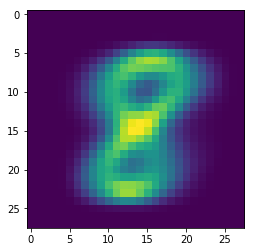

In [25]:
img = np.reshape(avg_eight, (28, 28))
plt.imshow(img)
plt.show()

In [26]:
num4 = train[2][0]
num8 = train[17][0]

weight = np.transpose(avg_eight)
# dot product of the weight and image number vectors
np.dot(weight, num4), np.dot(weight, num8)

(array([[20.066473]], dtype=float32), array([[54.196236]], dtype=float32))

In [39]:
# transform the output of the dot product to the range [0, 1].
# to define a cutoff value at 0.5 and declare everything above this value an 8.
def sigmoid_double(x):
    return 1.0 / (1.0 + np.exp(-x))


# computes the sigmoid for vectors


def sigmoid(z):
    return np.vectorize(sigmoid_double)(z)


# A simple prediction is defined by applying sigmoid to the output of np.doc(W, x) + b.


def predict(x, weight, bias):
    return sigmoid_double(np.dot(weight, x) + bias)


# Based on the examples computed so far we set the bias term to -45.
bias = -45
predict(num4, weight, bias), predict(num8, weight, bias)

(array([[1.4842492e-11]], dtype=float32), array([[0.99989855]], dtype=float32))

In [28]:
# average dot products for each number
# 0 = 45.965942
# 1 = 30.596882
# 2 = 44.91845
# 3 = 45.77951
# 4 = 38.09355
# 5 = 41.33466
# 6 = 41.18186
# 7 = 35.819122
# 8 = 54.832474
# 9 = 41.69966

In [29]:
# As indicated before, you define a cutoff, or decision threshold to decide whether a prediction is counted as a given digit
# use this evaluation function to assess the quality of predictions for data sets
#  As evaluation metric we choose accuracy, the ratio of correct predictions among all.
def evaluate(data, digit, threshold, weight, bias):
    total_samples = 1.0 * len(data)
    correct_predictions = 0

    for x in data:
        p = predict(x[0], weight, bias)
        # Predicting an instance of an eight as "8" is a correct prediction.
        if p > threshold and np.argmax(x[1]) == digit:
            correct_predictions += 1
        #  If the prediction is below our threshold and the sample is not an "8", we also predicted correctly.
        if p <= threshold and np.argmax(x[1]) != digit:
            correct_predictions += 1

    return correct_predictions / total_samples

In [40]:
threshold = 0.5

# Accuracy on training data of our simple model is 68%
e1 = evaluate(data=train, digit=8, threshold=threshold, weight=weight, bias=bias)

# Accuracy on test data is slightly lower, at 67%
e2 = evaluate(data=test, digit=8, threshold=threshold, weight=weight, bias=bias)

eight_test = [x for x in test if np.argmax(x[1]) == 8]
# Evaluating only on the set of eights in the test set only results in 81% accuracy
e3 = evaluate(data=eight_test, digit=8, threshold=threshold, weight=weight, bias=bias)

e1, e2, e3

(0.68278, 0.6735, 0.8121149897330595)

In [41]:
import random
import numpy as np

# We use mean squared error as our loss function
# You measure how close your prediction was to the actual label, by measuring the squared distance and averaging over all observed examples.
# The loss function for a set of predictions and labels gives you information about how well tuned the parameters of your model are.
# The smaller the loss, the better your predictions, and vice versa. The loss function itself is a function of the parameters of your network. In your MSE implementation, you don’t directly supply weights, but they’re implicitly given through predictions, because you use weights to compute them.


class MeanSquaredError:
    def __init__(self):
        pass

    @staticmethod
    def loss_function(predictions, labels):
        diff = predictions - labels
        # defining MSE as 0.5 times the square difference between predictions and labels
        return 0.5 * sum(diff * diff)[0]

    @staticmethod
    def loss_derivative(predictions, labels):
        return predictions - labels

In [32]:
def sigmoid_double(x):
    return 1.0 / (1.0 + np.exp(-x))


# computes the sigmoid for vectors


def sigmoid(z):
    return np.vectorize(sigmoid_double)(z)


def sigmoid_prime_double(x):
    return sigmoid_double(x) * (1 - sigmoid_double(x))


# computes the sigmoid for vectors


def sigmoid_prime(z):
    return np.vectorize(sigmoid_prime_double)(z)

In [33]:
import numpy as np

"""
deal with input data (the forward pass), but also a mechanism to propagate back error terms.
In order not to recompute activation values on the backward pass,
it’s practical to maintain the state of data coming into and out of the layer for both passes.

A layer has a list of parameters and stores both its current input and output data, as well as the respective input and output deltas for the backward pass. 
"""


class Layer:
    def __init__(self):
        self.params = []

        # A layer knows its predecessor
        self.previous = None
        # A layer knows its successor
        self.next = None

        # Each layer can persist data flowing into it in the forward pass.
        self.input_data = None
        # Each layer can persist data flowing out of it in the forward pass.
        self.output_data = None

        self.input_delta = None
        self.output_delta = None

    # give each layer a successor and a predecessor to allow for layer sequencing
    # This method connects a layer to its direct neighbours in the sequential network.
    def connect(self, layer):
        self.previous = layer
        layer.next = self

    # feed input data forward.
    def forward(self):
        raise NotImplementedError

    # nput_data is reserved for the first layer, all others get their input from the previous output.
    def get_forward_input(self):
        if self.previous is not None:
            return self.previous.output_data
        else:
            return self.input_data

    # Layers have to implement backpropagation of error terms, that is a way to feed input errors backward through the network.
    def backward(self):
        raise NotImplementedError

    # Input delta is reserved for the last layer, all other layers get their error terms from their successor.
    def get_backward_input(self):
        if self.next is not None:
            return self.next.output_delta
        else:
            return self.input_delta

    # reset deltas periodically, after accumulating deltas over mini-batches
    # We compute and accumulate deltas per mini-batch, after which we need to reset these deltas.
    def clear_deltas(self):
        pass

    # updating parameters for this layer, after the network using this layer tells it to
    # Update layer parameters according to current deltas, using the specified learning_rate.
    def update_params(self, learning_rate):
        pass

    def describe(self):
        raise NotImplementedError

In [34]:
# This activation layer uses the sigmoid function to activate neurons.
class ActivationLayer(Layer):
    def __init__(self, input_dim):
        super(ActivationLayer, self).__init__()

        self.input_dim = input_dim
        self.output_dim = input_dim

    #  take an input data sample x and pass it through the network to arrive at a prediction
    # applying the sigmoid to the input data.
    def forward(self):
        data = self.get_forward_input()
        self.output_data = sigmoid(data)

    # The backward pass is element-wise multiplication of the error term with the sigmoid derivative evaluated at the input to this layer.
    def backward(self):
        delta = self.get_backward_input()
        data = self.get_forward_input()
        self.output_delta = delta * sigmoid_prime(data)

    def describe(self):
        print("|-- " + self.__class__.__name__)
        print("  |-- dimensions: ({},{})".format(self.input_dim, self.output_dim))

In [35]:
import numpy as np


class DenseLayer(Layer):
    def __init__(self, input_dim, output_dim):
        super(DenseLayer, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim

        # randomly initialize weight matrix and bias vector.
        self.weight = np.random.randn(output_dim, input_dim)
        self.bias = np.random.randn(output_dim, 1)

        # The layer parameters consist of weights and bias terms.
        self.params = [self.weight, self.bias]

        # Deltas for weights and biases are set to zero.
        self.delta_w = np.zeros(self.weight.shape)
        self.delta_b = np.zeros(self.bias.shape)

    # the affine linear transformation on input data defined by weights and biases.
    def forward(self):
        data = self.get_forward_input()
        self.output_data = np.dot(self.weight, data) + self.bias

    def backward(self):
        # get input data and delta.
        data = self.get_forward_input()
        delta = self.get_backward_input()

        # The current delta is added to the bias delta.
        self.delta_b += delta

        # add this term to the weight delta.
        self.delta_w += np.dot(delta, data.transpose())

        # The backward pass is completed by passing an output delta to the previous layer.
        self.output_delta = np.dot(self.weight.transpose(), delta)

    # Using weight and bias deltas we can update model parameters with gradient descent.
    def update_params(self, rate):
        self.weight -= rate * self.delta_w
        self.bias -= rate * self.delta_b

    # After updating parameters we should reset all deltas.
    def clear_deltas(self):
        self.delta_w = np.zeros(self.weight.shape)
        self.delta_b = np.zeros(self.bias.shape)

    def describe(self):
        print("|--- " + self.__class__.__name__)
        print("  |-- dimensions: ({},{})".format(self.input_dim, self.output_dim))

In [42]:
# sequential neural network we stack layers sequentially.
class SequentialNetwork:
    def __init__(self, loss=None):
        print("Initialize Network...")
        self.layers = []
        # If no loss function is provided, MSE is used.
        if loss is None:
            self.loss = MeanSquaredError()

    # Whenever we add a layer, we connect it to its predecessor and let it describe itself.
    def add(self, layer):
        self.layers.append(layer)
        layer.describe()
        if len(self.layers) > 1:
            self.layers[-1].connect(self.layers[-2])

    # To train our network, we pass over data for as many times as there are epochs.
    def train(
        self, training_data, epochs, mini_batch_size, learning_rate, test_data=None
    ):
        n = len(training_data)

        for epoch in range(epochs):
            random.shuffle(training_data)
            # We shuffle training data and create mini-batches.
            mini_batches = [
                training_data[k : k + mini_batch_size]
                for k in range(0, n, mini_batch_size)
            ]

            # For each mini-batch we train our network.
            for mini_batch in mini_batches:
                self.train_batch(mini_batch, learning_rate)

            if test_data:
                n_test = len(test_data)
                print(
                    "Epoch {0}: {1} / {2}".format(
                        epoch, self.evaluate(test_data), n_test
                    )
                )
            else:
                print(f"Epoch {epoch} complete")

    # To train the network on a mini-batch, we compute feed-forward and backward pass.
    # and then update model parameters accordingly.
    def train_batch(self, mini_batch, learning_rate):
        self.forward_backward(mini_batch)

        self.update(mini_batch, learning_rate)

    def update(self, mini_batch, learning_rate):
        # normalize the learning rate by the mini-batch size.
        learning_rate = learning_rate / len(mini_batch)
        for layer in self.layers:
            layer.update_params(learning_rate)

        for layer in self.layers:
            layer.clear_deltas()

    def forward_backward(self, mini_batch):
        for x, y in mini_batch:
            self.layers[0].input_data = x
            # For each sample in the mini batch, feed the features forward layer by layer.
            for layer in self.layers:
                layer.forward()

            # compute the loss derivative for the output data.
            self.layers[-1].input_delta = self.loss.loss_derivative(
                self.layers[-1].output_data, y
            )

            # layer-by-layer backpropagation of error terms.
            for layer in reversed(self.layers):
                layer.backward()

    # Pass a single sample forward and return the result.
    def single_forward(self, x):
        self.layers[0].input_data = x
        for layer in self.layers:
            layer.forward()
        return self.layers[-1].output_data

    # In case we provided test data, we evaluate our network on it after each epoch.
    def evaluate(self, test_data):
        test_results = [
            (np.argmax(self.single_forward(x)), np.argmax(y)) for (x, y) in test_data
        ]

        return sum(int(x == y) for (x, y) in test_results)

In [37]:
training_data, test_data = load_data()

net = SequentialNetwork()

# To build a network, keep in mind that your input dimension is 784 and your output dimension is 10, the number of digits.
# You choose three dense layers with output dimensions 392, 196, and 10, respectively, and add sigmoid activations after each of them.
# With each new dense layer, you are effectively dividing layer capacity in half.
# The layer sizes and the number of layers are hyperparameters for this network.
# You’ve chosen these values to set up a network architecture.
# We encourage you to experiment with other layer sizes to gain intuition about the learning process of a network in relation to its architecture.
net.add(DenseLayer(784, 392))
net.add(ActivationLayer(392))
net.add(DenseLayer(392, 196))
net.add(ActivationLayer(196))
net.add(DenseLayer(196, 10))
net.add(ActivationLayer(10))

Initialize Network...
|--- DenseLayer
  |-- dimensions: (784,392)
|-- ActivationLayer
  |-- dimensions: (392,392)
|--- DenseLayer
  |-- dimensions: (392,196)
|-- ActivationLayer
  |-- dimensions: (196,196)
|--- DenseLayer
  |-- dimensions: (196,10)
|-- ActivationLayer
  |-- dimensions: (10,10)


In [38]:
# You train the network on data by calling train with all required parameters.
# You run training for 10 epochs and set the learning rate to 3.0.
# As mini-batch size, you choose 10, the number of classes.
# If you were to shuffle training data near perfectly, in most batches each class would be represented, leading to good stochastic gradients.
net.train(
    training_data, epochs=10, mini_batch_size=10, learning_rate=3.0, test_data=test_data
)

Epoch 0: 6723 / 10000
Epoch 1: 8418 / 10000
Epoch 2: 8522 / 10000
Epoch 3: 8607 / 10000
Epoch 4: 8616 / 10000
Epoch 5: 8678 / 10000
Epoch 6: 8703 / 10000
Epoch 7: 8708 / 10000
Epoch 8: 8743 / 10000
Epoch 9: 8767 / 10000
